In [1]:
import keras.metrics
import pandas as pd
import numpy as np
import seaborn as sns
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout
from keras import Sequential

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

## Erstelle aus `health-insurance.csv` einen DataFrame

In [17]:
insurance = pd.read_csv('./data/health-insurance.csv')

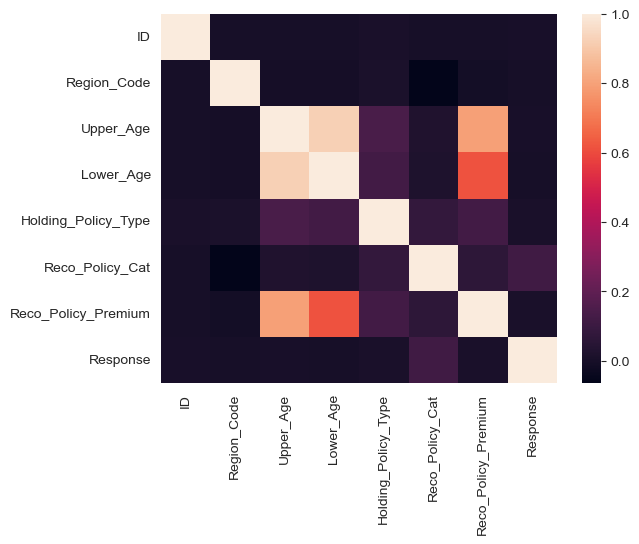

In [130]:
sns.heatmap(insurance.corr());

## Data Cleaning

* fehlende `Holding_Policy_Duration`/`Holding_Policy_Duration`-Werte sind gleich viele, sollten also gleich behandelt werden
* betrachte die Ausprägungen von `Health Indicator`. Auch hier gibt es einige `NaN`s

In [84]:
insurance.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [86]:
insurance.corr()["Response"]

ID                     0.005159
Region_Code            0.001121
Upper_Age              0.002772
Lower_Age             -0.002099
Holding_Policy_Type    0.009297
Reco_Policy_Cat        0.114321
Reco_Policy_Premium    0.007943
Response               1.000000
Name: Response, dtype: float64

In [18]:
insurance = insurance.drop(columns=["ID"])
insurance = pd.get_dummies(data=insurance, columns=["Accomodation_Type", "Reco_Insurance_Type", "Is_Spouse"],
                           drop_first=True)

In [19]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

insurance["Health Indicator"] = imputer.fit_transform(insurance["Health Indicator"].values.reshape(-1,1))
insurance["Health Indicator"] = insurance["Health Indicator"].str[1:]
insurance["Health Indicator"] = pd.to_numeric(insurance["Health Indicator"], downcast="signed")

insurance['Holding_Policy_Type'] = imputer.fit_transform(insurance["Holding_Policy_Type"].values.reshape(-1,1))
insurance['Holding_Policy_Type'] = pd.to_numeric(insurance['Holding_Policy_Type'], downcast="signed")

insurance["Holding_Policy_Duration"] = insurance["Holding_Policy_Duration"].replace({"14+": 15})
insurance["Holding_Policy_Duration"] = pd.to_numeric(insurance["Holding_Policy_Duration"], downcast="signed")
insurance["Holding_Policy_Duration"] = insurance["Holding_Policy_Duration"].fillna(0)

insurance["City_Code"] = pd.to_numeric(insurance["City_Code"].str[1:], downcast="signed")

insurance.dtypes

City_Code                       int8
Region_Code                    int64
Upper_Age                      int64
Lower_Age                      int64
Health Indicator                int8
Holding_Policy_Duration      float64
Holding_Policy_Type             int8
Reco_Policy_Cat                int64
Reco_Policy_Premium          float64
Response                       int64
Accomodation_Type_Rented       uint8
Reco_Insurance_Type_Joint      uint8
Is_Spouse_Yes                  uint8
dtype: object

In [ ]:
insurance.head()

In [23]:
insurance.corr()["Response"]

City_Code                   -0.005424
Region_Code                  0.001121
Upper_Age                    0.002772
Lower_Age                   -0.002099
Health Indicator             0.002239
Holding_Policy_Duration      0.014125
Holding_Policy_Type          0.006208
Reco_Policy_Cat              0.114321
Reco_Policy_Premium          0.007943
Response                     1.000000
Accomodation_Type_Rented    -0.005201
Reco_Insurance_Type_Joint    0.009891
Is_Spouse_Yes                0.003859
Name: Response, dtype: float64

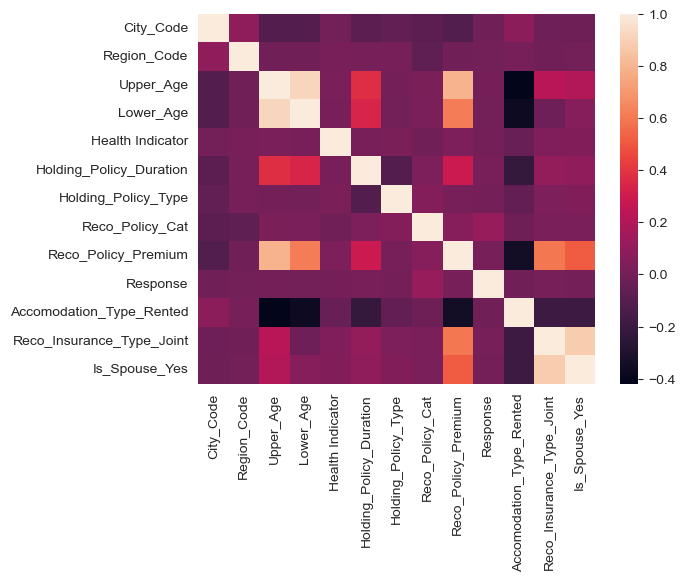

In [22]:
sns.heatmap(insurance.corr());

## Training
* 20% Testdaten
* `random_state=42` sofern unterstützt
* target feature: `Response`
* Überlege, welche Metrik maximiert werden soll (*accuracy*/*recall*/*f1*) und was die Business Implikation des erhaltenen Modells ist, diese Metrik geht in die `GridSearchCV` als `scoring` ein
* Trainiere mindestens
    * eine optimierte `LogisticRegression` mit `GridSearchCV` (optimiere `solver`, `C` und `class_weight`)
    * zwei ANNs (eins mit `class_weights` und eins ohne).
        `compile(metrics=[<metrik>]` kann entweder ein String übergeben werden oder eine Instanz einer Klasse aus `keras.metrics`

In [70]:
insurance.Response.value_counts()

0    38673
1    12209
Name: Response, dtype: int64

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = insurance.drop(columns="Response")
y = insurance["Response"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LinearRegression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


log_reg_cv = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'solver': ['sag', 'saga', 'newton-cg', 'lbfgs'],
        'class_weight': [None, 'balanced']
    },
    n_jobs=-1,
    scoring='precision',
    cv=5
)
log_reg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'solver': ['sag', 'saga', 'newton-cg', 'lbfgs']},
             scoring='precision')

In [24]:
log_reg_cv.score(X_test, y_test)

0.26717931937172773

In [25]:
from sklearn import metrics

metrics.confusion_matrix(y_test, (log_reg_cv.predict(X_test) > 0.5).astype("int32"))

array([[3209, 4479],
       [ 856, 1633]], dtype=int64)

## ANN

In [26]:
from keras.callbacks import EarlyStopping
cb_early_stop = EarlyStopping(
    monitor='val_precision',
    min_delta=0.05,
    patience=10,
    restore_best_weights=True,
    verbose=1)

In [27]:
ann_no_classweights = Sequential([
    Dense(units=50, activation='relu'),
    BatchNormalization(),
    Dense(units=50, activation='relu'),
    BatchNormalization(),
    Dense(units=50, activation='relu'),
    BatchNormalization(),
    Dense(units=50, activation='relu'),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])
ann_no_classweights.compile(optimizer='adam', loss='binary_crossentropy', metrics=keras.metrics.Precision(name='precision'))
history = ann_no_classweights.fit(X_train, y_train,
                                  callbacks=cb_early_stop,
                                  validation_data=(X_test, y_test),
                                  epochs=30,
                                  workers=-1,
                                  verbose=1
                                  )
history = pd.DataFrame(history.history)

Epoch 1/30
1273/1273 [==============================] - 7s 4ms/step - loss: 0.5658 - precision: 0.2494 - val_loss: 0.5556 - val_precision: 0.3333
Epoch 2/30
1273/1273 [==============================] - 5s 4ms/step - loss: 0.5446 - precision: 0.3571 - val_loss: 0.5517 - val_precision: 0.0000e+00
Epoch 3/30
1273/1273 [==============================] - 4s 3ms/step - loss: 0.5428 - precision: 0.2857 - val_loss: 0.5511 - val_precision: 0.0000e+00
Epoch 4/30
1273/1273 [==============================] - 5s 4ms/step - loss: 0.5407 - precision: 0.0000e+00 - val_loss: 0.5507 - val_precision: 0.0000e+00
Epoch 5/30
1273/1273 [==============================] - 4s 3ms/step - loss: 0.5401 - precision: 0.0000e+00 - val_loss: 0.5473 - val_precision: 0.0000e+00
Epoch 6/30
1273/1273 [==============================] - 4s 3ms/step - loss: 0.5399 - precision: 0.0000e+00 - val_loss: 0.5482 - val_precision: 0.0000e+00
Epoch 7/30
1273/1273 [==============================] - 5s 4ms/step - loss: 0.5390 - precisi

<AxesSubplot:>

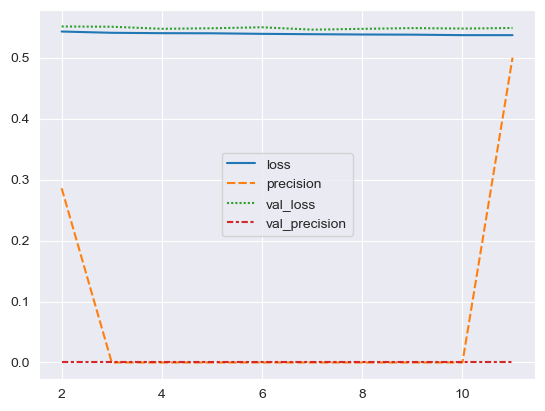

In [28]:
sns.lineplot(data=history[2:])

In [29]:
from sklearn import metrics

metrics.confusion_matrix(y_test, (ann_no_classweights.predict(X_test) > 0.5).astype("int32"))

319/319 [==============================] - 1s 2ms/step


array([[7688,    0],
       [2489,    0]], dtype=int64)

In [30]:
print(metrics.classification_report(y_test, (ann_no_classweights.predict(X_test) > 0.5).astype("int32")))

319/319 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7688
           1       0.00      0.00      0.00      2489

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.57      0.76      0.65     10177



C:\Users\Flo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Flo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Flo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [147]:
class_weights = dict(zip([0, 1], insurance.Response.value_counts().sum() / insurance.Response.value_counts()))
class_weights

{0: 1.315698290797197, 1: 4.167581292489148}

In [32]:
import numpy as np
from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train),y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train),
                                                              y= y_train)))
class_weights

{0: 0.6568500887526222, 1: 2.093878600823045}

In [34]:
cb_precision = EarlyStopping(
        monitor='val_precision',
        min_delta=0.05,
        patience=10,
        restore_best_weights=True,
        verbose=1)

In [41]:
import keras
ann_classweights = Sequential([
    Dense(units=300, activation='relu'),
    BatchNormalization(),
    Dense(units=300, activation='relu'),
    BatchNormalization(),
    Dense(units=100, activation='relu'),
    BatchNormalization(),
    Dense(units=100, activation='relu'),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])
ann_classweights.compile(optimizer='adam', loss='binary_crossentropy', metrics=keras.metrics.Precision(name='precision'))
history = ann_classweights.fit(X_train, y_train,
                                  callbacks=cb_precision,
                                  validation_data=(X_test, y_test),
                                  epochs=30,
                                  workers=-1,
                                  verbose=1,
                                  class_weight=class_weights,
                                  )
history = pd.DataFrame(history.history)

Epoch 1/30
1273/1273 [==============================] - 10s 6ms/step - loss: 0.7057 - precision: 0.2609 - val_loss: 0.6711 - val_precision: 0.2670
Epoch 2/30
1273/1273 [==============================] - 6s 5ms/step - loss: 0.6850 - precision: 0.2627 - val_loss: 0.6876 - val_precision: 0.2736
Epoch 3/30
1273/1273 [==============================] - 8s 6ms/step - loss: 0.6817 - precision: 0.2647 - val_loss: 0.6786 - val_precision: 0.2684
Epoch 4/30
1273/1273 [==============================] - 7s 5ms/step - loss: 0.6813 - precision: 0.2646 - val_loss: 0.6703 - val_precision: 0.2772
Epoch 5/30
1273/1273 [==============================] - 6s 5ms/step - loss: 0.6802 - precision: 0.2686 - val_loss: 0.7020 - val_precision: 0.2693
Epoch 6/30
1273/1273 [==============================] - 7s 5ms/step - loss: 0.6795 - precision: 0.2662 - val_loss: 0.7054 - val_precision: 0.2657
Epoch 7/30
1273/1273 [==============================] - 6s 5ms/step - loss: 0.6786 - precision: 0.2666 - val_loss: 0.6751 -

<AxesSubplot:>

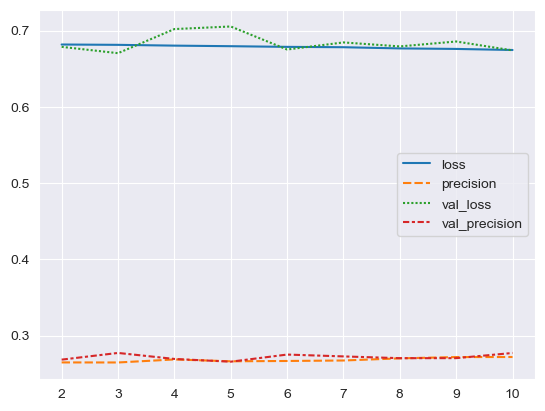

In [44]:
sns.lineplot(data=history[2:])

In [46]:
metrics.confusion_matrix(y_test, (ann_classweights.predict(X_test) > 0.5).astype("int32"))

319/319 [==============================] - 1s 2ms/step


array([[4585, 3103],
       [1359, 1130]], dtype=int64)

In [47]:
print(metrics.classification_report(y_test, (ann_classweights.predict(X_test) > 0.5).astype("int32")))

319/319 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.60      0.67      7688
           1       0.27      0.45      0.34      2489

    accuracy                           0.56     10177
   macro avg       0.52      0.53      0.50     10177
weighted avg       0.65      0.56      0.59     10177



## Evaluiere die Modelle und Interpretiere deine Lösung bezüglich *precision*/*recall*/*f1*